# Convolutional Neural Networks

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from flax import linen as nn

This notebook makes extensive use of examples and figures from [here](http://cs231n.github.io/convolutional-networks/), which is a great reference for further details.

In [5]:
train_ds = tfds.load('fashion_mnist', split='train')
test_ds = tfds.load('fashion_mnist', split='test')

## MNIST - Fashion

... a collection of small 28x28 pixel images of various pieces of clothing. This is a multi-class classification problem, identify the type of object in the image

|Label| Class  |
|------ | ------|
|    0|T-shirt/top|
|    1|Trouser|
|    2| Pullover|
|    3| Dress|
|    4| Coat|
|    5| Sandal|
|    6| Shirt|
|    7| Sneaker|
|    8| Bag|
|    9| Ankle boot|

In [6]:
n_classes = 10

# This is useful for making plots it takes an integer
lookup_dict={
    0:'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot'
}

labels = list(lookup_dict.values())

Regularize the data.

In [7]:
train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                        'label': sample['label']}) # normalize train set
test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                    'label': sample['label']}) # normalize test set

Batch up the data.

In [8]:
tf.random.set_seed(0) # ensure dataset shuffling

In [9]:
num_epochs = 50
batch_size = 32

# shuffle data by allocating a buffer of 1024 to randomly draw examples from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
test_ds = test_ds.shuffle(1024)

# group into batches of 32, skip incomplete batch, prefetch next sample to speed up
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [10]:
class DenseNN(nn.Module):
  """A simple model with densely connected layers."""

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))   # flatten
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=n_classes)(x)
    return x

In [11]:
import jax
import jax.numpy as jnp  # JAX NumPy

dummy_input = jnp.ones((1, 28, 28, 1))

dnn = DenseNN()
print(dnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1))))


                                DenseNN Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs             ┃ outputs        ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ DenseNN │ float32[1,28,28,1] │ float32[1,10]  │                    │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_0 │ Dense   │ float32[1,784]     │ float32[1,100] │ bias: float32[100] │
│         │         │                    │                │ kernel:            │
│         │         │                    │                │ float32[784,100]   │
│         │         │                    │                │                    │
│         │         │                    │                │ 78,500 (314.0 KB)  │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_1 │ Dense   │ float

Now we prepare for training.

In [12]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

# state = create_train_state(dnn, init_rng, learning_rate, momentum)
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [14]:
init_rng = jax.random.PRNGKey(0)
learning_rate = 0.01
state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [15]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
num_steps_per_epoch

1875

In [16]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [17]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.47918373346328735, accuracy: 82.59666442871094
test epoch: 1, loss: 0.45451653003692627, accuracy: 83.70392608642578
train epoch: 2, loss: 0.4042518138885498, accuracy: 85.26667022705078
test epoch: 2, loss: 0.45403459668159485, accuracy: 83.55368041992188
train epoch: 3, loss: 0.3819248676300049, accuracy: 86.07333374023438
test epoch: 3, loss: 0.5412045121192932, accuracy: 81.00961303710938
train epoch: 4, loss: 0.3712323307991028, accuracy: 86.51333618164062
test epoch: 4, loss: 0.4784495532512665, accuracy: 82.94270324707031
train epoch: 5, loss: 0.3619953989982605, accuracy: 86.82500457763672
test epoch: 5, loss: 0.45991674065589905, accuracy: 84.28485107421875
train epoch: 6, loss: 0.3632104694843292, accuracy: 86.77666473388672
test epoch: 6, loss: 0.4377463757991791, accuracy: 85.19631958007812
train epoch: 7, loss: 0.3521922528743744, accuracy: 87.38333892822266
test epoch: 7, loss: 0.46046605706214905, accuracy: 84.73558044433594
train epoch: 8, loss: 

After a fair amount of training we found a ~$86\%$ validation accuracy.  OK, but not great.  Let's take another look at the summary.

Our first layer has $28 \times 28 \times 1 \times 100 = 78,500$ weights, which is manageable.  What if we had higher-resolution images?  Let's go with a modest $300 \times 300$ pixel input.  That would be $300 \times 300 \times 3 \times 100= 27$ Million parameters for one layer. This is still possible with modern GPUs, but does not generally yield good results. We need a solution that scales better with the number of pixels!

A $300\times300\times3$ pixel image:
<img src="https://raw.githubusercontent.com/jsearcy1/racsml/master/assets/small_img.jpg" style="width:100">

# Convolutional Neural Networks


The fully connected neural network becomes cumbersome when we start considering image recognition; it needs *lots* of weights, and isn't designed to take advantage of spatial features in the inputs.  This is where CNNs become powerful.
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg" style="width:100">


CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" style="width=100">

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of pixels in the output of a convolutional layer is $(W−F+2P)/S+1$. 

<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

Above is a 1-D example with inputs on the bottom in blue ($W=5$) with a padding of 1 ($P=1$), and two different examples of a convolutional filter, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 1$, meaning we expect ($5 - 3 + 2)/1+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

### Parameter sharing

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position $(x,y)$, then it should also be useful to compute at a different position $(x_2,y_2)$.

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the pixels in each depth slice to use the same weights and bias. All $7\times7$ pixels in each depth slice will now be using the same parameters.


<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">



Lets look at the how the first output pixel is calculated

|X[0:3,0:3,0]|W0[:,:,0]| 
|------ | ------|
|0,0,0  |-1,0,1|
|0,0,0  |0,0,1 |
|0,1,0  |1,-1,1|
|first channel = | -1|
+
|X[0:3,0:3,1]|W0[:,:,1]|
|0,0,0  |-1,0,1|
|0,2,1  |1,-1,1|
|0,2,1  |0,1,0|
|second channel = |1|
+
|X[0:3,0:3,2]|W0[:,:,2]|
|0,0,0  |-1,1,1|
|0,2,1  |1,1,0 |
|0,1,0  |0,-1,0|
|third channel= | 1|
|bias = |1 |
|Sum Total| 2 = O[0,0,0]|



## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" style="width:300">

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" style="width:500">

**NOTE**: These are being used less and less these days, in favor of other methods such as strided convolutions seen above.



Let's return to the MNIST fasion data set.  First we'll download some external images that will be useful for visualizations later.

# Data Shape

Convolutional layers expect to handle 3-D data cubes, so we'll need to do a little reshaping of our dataset.

In [18]:
train_ds.element_spec

{'image': TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float32, name=None),
 'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)}

## The Model

We'll now build our (sequential) model using `Flax`.

In [19]:
n_classes = 10

class ConvNN(nn.Module):
  """A simple model with densely connected layers."""

  @nn.compact
  def __call__(self, x, training: bool):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Dropout(rate=0.25, deterministic=not training)(x)
    x = x.reshape((x.shape[0], -1))   # flatten
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.Dropout(rate=0.5, deterministic=not training)(x)
    x = nn.Dense(features=n_classes)(x)
    return x

Our first layer (after the input layer) will be a convolutional layer with `32` filters.
* Conv( Filters, (filter height, filter width), strides=1, padding='None' )

Now let's add on another `32`-filter convolutional layer, followed by a 2-D pooling layer with a pooling size of `2x2`.

Next we'll add on a *dropout* layer.  This layer will set the specified fraction of inputs to `0`, which can be useful for avoiding over fitting.  We'll drop $25\%$ of the inputs with this layer.   

Next we'll add a fully connected layer with `128` nodes, making sure to flatten the volume before passing to this layer.

We'll now add one final $25\%$ dropout layer for good measure, followed by the output layer.

Now let's add our output layer.  Like with the dense netwok above, we need one node be possible category, and we'll use the `softmax` activation function since we're building a multi-class classifier.

Let's see the final network.

In [20]:
dummy_input.shape

(1, 28, 28, 1)

In [21]:
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = ConvNN()
print(cnn.tabulate(jax.random.PRNGKey(0), dummy_input, training=False))


                                 ConvNN Summary                                 
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs           ┃ outputs          ┃ params           ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│           │ ConvNN  │ -                │ float32[1,10]    │                  │
│           │         │ float32[1,28,28… │                  │                  │
│           │         │ - training:      │                  │                  │
│           │         │ False            │                  │                  │
├───────────┼─────────┼──────────────────┼──────────────────┼──────────────────┤
│ Conv_0    │ Conv    │ float32[1,28,28… │ float32[1,28,28… │ bias:            │
│           │         │                  │                  │ float32[32]      │
│           │         │                  │                  │ kernel:          │
│           │         │    

The first thing to note is that we have $813802$ trainable parameters in this network, compared to the $89610$ parameters in the dense network we constructed previously.

Now that we've built our full model it's time to compile it, specifying the loss function, optimizer, and any metrics we want to look at, and fit on the training data.

In [45]:
init_rng, dropout_rng = jax.random.split(jax.random.PRNGKey(0), 2)

In [46]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   key: jax.random.KeyArray
   metrics: Metrics

def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input, training=False)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params,
        key=dropout_rng, tx=tx,
        metrics=Metrics.empty())

@jax.jit
def train_step(state, batch, dropout_rng):
  """Train for a single step."""
  dropout_train_key = jax.random.fold_in(key=dropout_rng, data=state.step)
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'],
                            training=True, rngs={'dropout': dropout_train_key})
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'], training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [47]:
learning_rate = 0.01
# momentum = 0.9

state = create_train_state(cnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [48]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [49]:
n_epochs = 10

# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
num_steps_per_epoch

1875

In [50]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch, dropout_rng) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.38853853940963745, accuracy: 85.75999450683594
test epoch: 1, loss: 0.36797791719436646, accuracy: 86.28805541992188
train epoch: 2, loss: 0.32103052735328674, accuracy: 87.89167022705078
test epoch: 2, loss: 0.34759488701820374, accuracy: 87.32972717285156
train epoch: 3, loss: 0.30900838971138, accuracy: 88.37333679199219
test epoch: 3, loss: 0.3905026316642761, accuracy: 85.29647827148438
train epoch: 4, loss: 0.29859408736228943, accuracy: 88.62333679199219
test epoch: 4, loss: 0.3532487750053406, accuracy: 86.66867065429688
train epoch: 5, loss: 0.29612162709236145, accuracy: 88.65333557128906
test epoch: 5, loss: 0.3433508574962616, accuracy: 87.37980651855469
train epoch: 6, loss: 0.2853774428367615, accuracy: 89.3116683959961
test epoch: 6, loss: 0.330453485250473, accuracy: 88.02082824707031
train epoch: 7, loss: 0.28389349579811096, accuracy: 89.28333282470703
test epoch: 7, loss: 0.3795185387134552, accuracy: 85.75721740722656
train epoch: 8, loss: 0.

KeyboardInterrupt: 

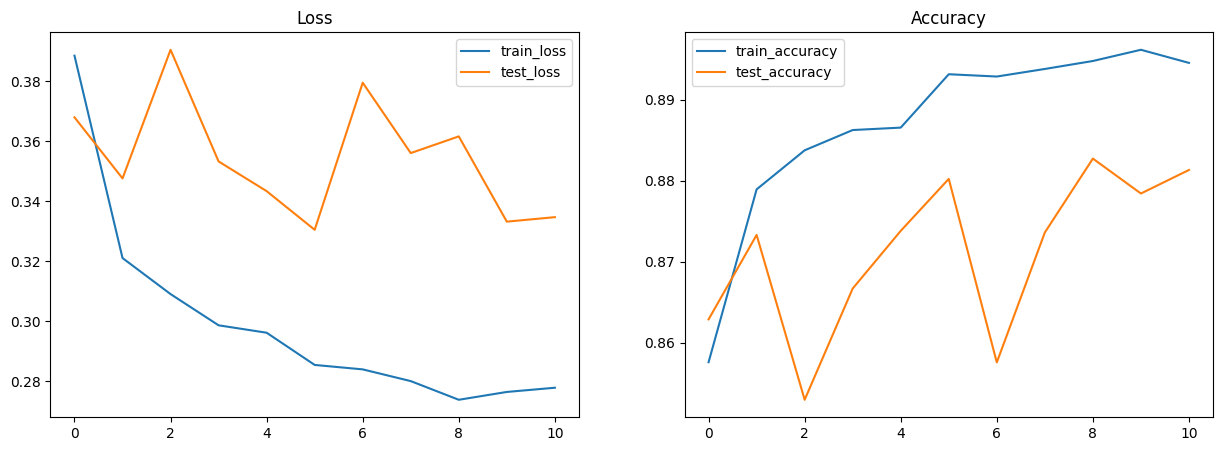

In [51]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend();

In [78]:
@jax.jit
def predict(state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'], training=False)
  return logits.argmax(axis=1)

# Prediction
Lets look at how the model makes predictions


outputs:
T-shirt/top 0.61
Trouser -3.83
Pullover 1.99
Dress -2.1399999
Coat -0.71
Sandal -7.74
Shirt 0.58
Sneaker -11.21
Bag -2.95
Ankle boot -11.95
best guess: [2 4 3 4 8 7 4 7 2 3 9 7 0 2 5 1 9 3 6 2 5 9 1 2 5 7 6 8 4 3 5 5]
Truth Class: 2 Pullover


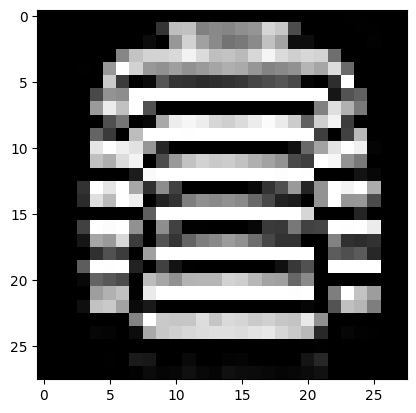

In [84]:
for batch in test_ds.as_numpy_iterator():
    pred = predict(state, batch)
    logits = state.apply_fn({'params': state.params}, batch['image'], training=False)
    test_idx = np.random.randint(len(pred))
    print("outputs:")
    for i, p in enumerate(logits[test_idx]):
        print(lookup_dict[i], round(p,2))

    print('best guess:', pred)
    plt.imshow(np.squeeze(batch['image'][test_idx]),cmap='gray')

    print('Truth Class:',batch['label'][test_idx],lookup_dict[batch['label'][test_idx]]);
    break


## Other Checks

### Confusion matrix
A confusion matrix is a 2-D histogram with the dimensions being the true class, and the predicted class.
The diagonal bins in this histogram are correct prediction true_class==predicted_class, otherwise it is an
incorrect prediction. Run the cell below and see if you can guess which class is hardest to identify

In [98]:
def check(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'], training=False)
    pred = predict(state, batch)
    confusion_matrix = np.zeros((n_classes, n_classes))

    for truth, guess in zip(batch['label'], pred):
        confusion_matrix[truth, guess] += 1

    plt.imshow(confusion_matrix)
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(0,10), labels, rotation=90)
    plt.yticks(range(0,10), labels)
    plt.show()

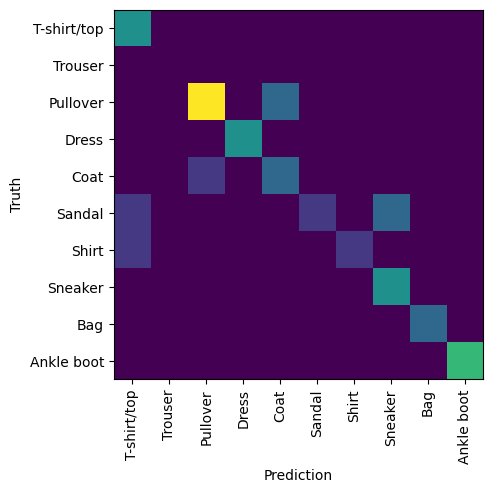

In [99]:
for batch in test_ds.as_numpy_iterator():
    check(state, batch)
    break